In [12]:
import pandas
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
from sklearn import preprocessing
import tensorflow as tf
import math

In [13]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


In [14]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [15]:
df = pandas.read_csv("../nyse/prices-split-adjusted.csv",index_col = 0)
df = df[df.symbol == 'GOOG']
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df.drop(['symbol'],1,inplace=True)

In [16]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df
df = normalize_data(df)

In [17]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    print result.shape
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]
    print x_train[0:2]
    print y_train[0]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [18]:
window = 4
X_train, y_train, X_test, y_test = load_data(df, window)

(1757, 5, 5)
[[[ 0.15704696  0.16116746  0.15638998  0.1317225   0.15939908]
  [ 0.15723843  0.15888449  0.15499506  0.20246902  0.15709185]
  [ 0.15613951  0.14604929  0.15334121  0.26818406  0.14394234]
  [ 0.14243617  0.13445699  0.14009362  0.43252209  0.13210528]]

 [[ 0.15723843  0.15888449  0.15499506  0.20246902  0.15709185]
  [ 0.15613951  0.14604929  0.15334121  0.26818406  0.14394234]
  [ 0.14243617  0.13445699  0.14009362  0.43252209  0.13210528]
  [ 0.12795029  0.13146379  0.13445546  0.3184921   0.13872603]]]
0.138726029615


In [19]:
model = build_model([5,window,1])

('Compilation Time : ', 0.028736114501953125)


In [20]:
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Train on 1422 samples, validate on 159 samples
Epoch 1/90
1422/1422 [==============================] - 2s - loss: 0.1302 - acc: 7.0323e-04 - val_loss: 0.6317 - val_acc: 0.0000e+00
Epoch 2/90
1422/1422 [==============================] - 0s - loss: 0.1148 - acc: 7.0323e-04 - val_loss: 0.5113 - val_acc: 0.0000e+00
Epoch 3/90
1422/1422 [==============================] - 0s - loss: 0.0798 - acc: 7.0323e-04 - val_loss: 0.2319 - val_acc: 0.0000e+00
Epoch 4/90
1422/1422 [==============================] - 0s - loss: 0.0215 - acc: 7.0323e-04 - val_loss: 0.0190 - val_acc: 0.0000e+00
Epoch 5/90
1422/1422 [==============================] - 0s - loss: 0.0274 - acc: 7.0323e-04 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 6/90
1422/1422 [==============================] - 0s - loss: 0.0073 - acc: 7.0323e-04 - val_loss: 0.0611 - val_acc: 0.0000e+00
Epoch 7/90
1422/1422 [==============================] - 0s - loss: 0.0111 - acc: 7.0323e-04 - val_loss: 0.1040 - val_acc: 0.0000e+00
Epoch 8/90
1422/1422 [

1422/1422 [==============================] - 0s - loss: 6.9921e-04 - acc: 7.0323e-04 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 61/90
1422/1422 [==============================] - 0s - loss: 7.3992e-04 - acc: 7.0323e-04 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 62/90
1422/1422 [==============================] - 0s - loss: 6.4806e-04 - acc: 7.0323e-04 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 63/90
1422/1422 [==============================] - 0s - loss: 6.9121e-04 - acc: 7.0323e-04 - val_loss: 0.0024 - val_acc: 0.0000e+00
Epoch 64/90
1422/1422 [==============================] - 0s - loss: 6.4370e-04 - acc: 7.0323e-04 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 65/90
1422/1422 [==============================] - 0s - loss: 6.9592e-04 - acc: 7.0323e-04 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 66/90
1422/1422 [==============================] - 0s - loss: 6.5732e-04 - acc: 7.0323e-04 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 67/90
1422/1422 [=======================

In [21]:
model.save('models/model_google.h5')

In [22]:
p = model.predict(X_test)

In [23]:
df = pandas.read_csv("../nyse/prices-split-adjusted.csv", index_col = 0)
df = df[df.symbol == 'GOOG']
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df.drop(['symbol'],1,inplace=True)

# Bug fixed at here, please update the denormalize function to this one
def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)
# newp = p
# newy_test = y_test

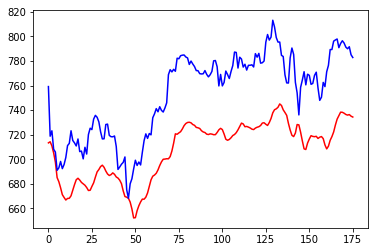

In [24]:
plt.plot(newp,color='red', label='Prediction')
plt.plot(newy_test,color='blue', label='Actual')
plt.savefig('../graph/Illumina.png')

In [25]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [26]:
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00080 MSE (0.03 RMSE)
Test Score: 0.00635 MSE (0.08 RMSE)


(0.00079792189196218688, 0.0063547149131243878)